## Notebook objectives

Classify Clusters in a Business sense and Exctract strategies to make more money out of them.


## Agenda

[Business Context](#Business-Context)<br> 
&emsp;[Business Questions](#Business-Questions)<br>

[Imports](#Imports)<br>
&emsp;[Helper Functions and Classes](#Helper-Functions-and-Classes)<br>

[Settings](#Settings)<br>

[Loading Data](#Loading-Data)<br>
&emsp;[df_clusters](#df_clusters)<br>
&emsp;&emsp;[df_kmeans_clusters](#df_clusters)<br>
&emsp;&emsp;[df_dbscan_clusters](#df_clusters)<br>
&emsp;&emsp;[df_agglomerative_clustering](#df_clusters)<br>
&emsp;[df_payments](#df_payments)<br>
&emsp;[df_products](#df_products)<br>
&emsp;[df_order_items](#df_order_items)<br>
&emsp;[df_geolocations](#df_geolocations)<br>
&emsp;[df_customers](#df_customers)<br>


[Analytical Base Table](#Analytical-Base-Table)<br>
&emsp;[ABT Metadata](#ABT-Metadata)<br>
&emsp;[df_payment_abt](#df_payment_abt)<br>
&emsp;[df_orders_abt](#df_orders_abt)<br>
&emsp;[df_geolocation_abt](#df_geolocation_abt)<br>

[Analysis](#Analysis)<br>
&emsp;[K-Means](#K-Means)<br>
&emsp;[DBScan](#DBScan)<br>
&emsp;[AgglomerativeClustering](#AgglomerativeClustering)<br>

[Final Clusters](#Final-Clusters)<br>



## Business Context

E-Mart is a Chinese retailer that discovered the e-commerce as a way to sell to the entire world, rather than just to the population of their home city. The company has been growing without much worries, and now It wants to start using the data collected during its 4 years of e-commerce to keep growing and make more money.


The company has been growing without much worries, and now It wants to start using the data collected during the years to keep growing and make more money.
At first, the board of directors expects:

- A Dashboard with KPIs to track their growth.
<br>

- Robust Data Analysis, as well as recommendation of actions. What's the actionable based on your analysis?
<br>

- **An Analysis on geolocation, a segmentation by sales, profit and more. They want insights to help increasing revenue.**
<br>

- Sales forecast for the next year, in order to enable strategic planning.



### Business Questions

**How can we group markets by geolocation and profit from it? What are their characteristics?**

## Hypothesis


Why are discounts so high in a cluster? Were they applied in the initial sales period to expand the brand and win customers?

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Helper Functions and Classes

In [2]:
def get_snakecase_columns(df):
    """Sets column name to snake_case format
    
    df: pandas.DataFrame
    
    Return: map
    """
    snakecase = lambda x: str(x).lower().replace(' ', '_').replace('-', '_')
    return map(snakecase, df.columns)

def date(str_date):
    """Apply pandas.to_datetime to argument converting it to datetime.
        
    """
    return pd.to_datetime(str_date)

def find_column(df, col_name):
    """Checks if DataFrame contains a 'column name' and returns the matched columns
    
    df: pandas.DataFrame
    col_name: column name or part of column name to search for
    
    Return: DataFrame with column names that match the col_name searched
    """
    
    df_cols = pd.DataFrame(df.columns, columns=['col_name'])

    return df_cols[df_cols['col_name'].str.contains(col_name)].reset_index(drop=True)


def fig(x=15, y=5, set_as_global=False, reset_to_default=False):
    """ Adjust size of matplotlib figure

    x: figure width.
    y: figure height.
    set_as_global: bool.
        If True, then it sets "x" and "y" axis for all subsequent plots.
    reset_to_default: bool.
        If True, then it resets the global figure size back to default.
    """
    if set_as_global:
        plt.rcParams["figure.figsize"] = (x, y)
    elif reset_to_default:
        plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]
    else:
        plt.figure(figsize=(x,y))
        
def cluster_stats(df, column, cluster='cluster', quantile_1=.8, quantile_2=.9):    
    stats = df.groupby(cluster)[[column]].describe()[column]
    quantiles = pd.concat([df.groupby(cluster)[[column]].quantile(quantile_1), df.groupby(cluster)[[column]].quantile(quantile_2)], axis=1)
    quantile_1_name, quantile_2_name = f'{round(quantile_1*100)}%', f'{round(quantile_2*100)}%'
    quantiles.columns = [quantile_1_name, quantile_2_name]
    stats = pd.concat([stats, quantiles], axis=1)
    return stats[['mean', 'std', 'min', '25%', '50%', '75%', quantile_1_name, quantile_2_name, 'max']]


def agg(df):
    return (df.groupby(['cluster'])
                .agg(
                    n_countries=('country', 'nunique'),
                    n_orders=('order_id','nunique'),
                    n_products=('n_products','sum'),
                    avg_products_per_order=('n_products','mean'),
                    n_customers=('customer_id','nunique'),
                    total_sales=('sales','sum'),
                    total_profit=('profit','sum'),
                    avg_sales=('sales','mean'),
                    avg_profit=('profit','mean'),
                    avg_discount=('avg_discount','mean'),
                    avg_product_price=('avg_product_price','mean'),
                    avg_shipping_cost=('shipping_cost','mean'),
                    avg_delivery_time=('delivery_time','mean'),
                    avg_days_to_ship=('days_to_ship','mean'),
                    avg_delayed_days=('delayed_days','mean'),
                    avg_delivery_on_time=('delivery_on_time','mean'),
                    profitable_rate=('profitable','mean')
                )
            ).round(2)

def get_cluster_palette(categories, colors=None):
    """
    Defines colors of category for customer segmentation plots.

    Parameters
    ----------
    categories: category name or list of categories to set a color.
    
    colors: list of colors to be used to color the categories.
             if None: ['#034488', '#027dc5', '#c5253d']
    
    Returns
    -------
    segment_color: dict of categories and respective colors.
    """
    
    if colors is None:
        colors = ['#034488', '#027dc5', '#c5253d']
    segment_color = {}
    if isinstance(categories, list):
        for i in range(len(categories)):
            segment_color[categories[i]] = colors[i]
    else:
        segment_color[categories] = colors[0]
    return segment_color

### Settings

In [ ]:
%matplotlib inline

In [3]:
pd.set_option('display.max_columns', 500)

fig(12,4, set_as_global=True)

## Loading Data

### df_clusters


In [4]:
df_kmeans_clusters = pd.read_csv("../../data/country_clusters/kmeans_clusters.csv")
df_dbscan_clusters = pd.read_csv("../../data/country_clusters/dbscan_clusters.csv")
df_agglomerative_clustering = pd.read_csv("../../data/country_clusters/agglomerative_clustering.csv")

### df_orders

In [5]:
df_orders = pd.read_csv("https://raw.githubusercontent.com/pauloreisdatascience/datasets/main/e_market/e_mart_orders_table.csv")
df_orders.columns = get_snakecase_columns(df_orders)

df_orders['customer_id'] = df_orders['customer_id'].apply(lambda x: x[2:-2])
df_orders['order_date'] = df_orders['order_date'].apply(date)
df_orders['ship_date'] = df_orders['ship_date'].apply(date)
df_orders['delivery_date'] = df_orders['delivery_date'].apply(date)
df_orders['deadline_date'] = df_orders['deadline_date'].apply(date)
df_orders['order_priority'] = df_orders['order_priority'].apply(lambda x: x[2:-2])
df_orders = df_orders.assign(postal_code=df_orders['postal_code'].apply(lambda x: int(x[2:-2])))

In [6]:
df_orders.duplicated(subset=['order_id']).sum()

0

### df_payments

In [7]:
df_payments = pd.read_csv("https://raw.githubusercontent.com/pauloreisdatascience/datasets/main/e_market/e_mart_payment_table.csv")
df_payments.columns = get_snakecase_columns(df_payments)

In [8]:
df_payments.duplicated(subset=['order_id']).sum()

0

### df_products

In [9]:
df_products = pd.read_csv("https://raw.githubusercontent.com/pauloreisdatascience/datasets/main/e_market/e_mart_products_table.csv")
df_products.columns = get_snakecase_columns(df_products)

In [10]:
df_products.duplicated(subset=['product_id']).sum()

0

### df_order_items

In [11]:
df_order_items = pd.read_csv("https://raw.githubusercontent.com/pauloreisdatascience/datasets/main/e_market/e_mart_order_items_table.csv")
df_order_items.columns = get_snakecase_columns(df_order_items)

In [12]:
df_order_items.duplicated(subset=['order_item_id']).sum()

35

### df_geolocations

In [13]:
df_geolocations = pd.read_csv("https://raw.githubusercontent.com/pauloreisdatascience/datasets/main/e_market/e_mart_geolocation_table.csv")
df_geolocations.columns = get_snakecase_columns(df_geolocations)

In [14]:
df_geolocations.duplicated(subset=['postal_code']).sum()

0

### df_customers

In [15]:
df_customers = pd.read_csv("https://raw.githubusercontent.com/pauloreisdatascience/datasets/main/e_market/e_mart_customers_table.csv")
df_customers.columns = get_snakecase_columns(df_customers)

In [16]:
df_customers.duplicated(subset=['customer_id']).sum()

0

## Analytical Base Table

### ABT Metadata

[df_orders_abt](#df_orders_abt)<br>



### df_payment_abt

In [17]:
df_payment_abt = df_order_items.merge(df_products, how='left', on=['product_id'])

df_payment_abt['sales'] = (
    (df_payment_abt['quantity']*df_payment_abt['product_price'] *(1-df_payment_abt['discount']))
    + df_payment_abt['shipping_cost']
)

cols = ['order_item_id', 'order_id', 'product_id',
        'quantity', 'product_price', 'discount',
        'shipping_cost', 'sales']
df_payment_abt = df_payment_abt[cols]


df_payment_abt = (
    df_payment_abt.groupby('order_id')
                    .agg(n_products=('quantity', 'sum'),
                         total_discount=('discount', 'sum'),
                         avg_discount=('discount', 'mean'),
                         avg_product_price=('product_price', 'mean'),
                         shipping_cost=('shipping_cost', 'sum'),
                         sales=('sales', 'sum'),
                         max_product_price=('product_price', 'max'),
                         min_product_price=('product_price', 'min')
                        )
)

# Check if Payment and Sales are equal
# df_payment_abt = df_payment_abt.merge(df_payments.rename(columns={'sales':'payment'}),
#                                       how='left', on=['order_id'])

df_payment_abt.head(2)

,n_products,total_discount,avg_discount,avg_product_price,shipping_cost,sales,max_product_price,min_product_price
order_id,,,,,,,,
AE-2011-9160-PO-8865,8,1.4,0.7,110.775909,9.56,176.424976,193.273579,28.278238
AE-2013-1130-EB-4110,7,1.4,0.7,52.947440,60.18,242.152214,100.135833,5.759048


### df_orders_abt


In [18]:
df_orders_abt = (df_orders
         .merge(df_geolocations, how='left', on='postal_code')
         .merge(df_customers, how='left', on='customer_id')
         .merge(df_payments, how='left', on=['order_id'])
)

df_orders_abt['order_date_monthly'] = df_orders_abt['order_date'].dt.to_period("M")#.dt.to_timestamp(freq='M')
df_orders_abt['market_region'] = df_orders_abt['market'] +" | " + df_orders_abt['region']
df_orders_abt['delivery_time'] = (df_orders_abt['delivery_date'] - df_orders_abt['order_date']).dt.days
df_orders_abt['expected_delivery_time'] = (df_orders_abt['deadline_date'] - df_orders_abt['order_date']).dt.days
df_orders_abt['days_to_ship'] = (df_orders_abt['ship_date'] - df_orders_abt['order_date']).dt.days
df_orders_abt['delayed_days'] = df_orders_abt['delivery_time'] - df_orders_abt['expected_delivery_time']
df_orders_abt['delivery_on_time'] = df_orders_abt['delayed_days'].apply(lambda x: True if x <= 0
                                                                        else False)
df_orders_abt['profitable'] = df_orders_abt['profit'].apply(lambda x: True if x>0 else False)

df_orders_abt = df_orders_abt.merge(df_payment_abt.drop(columns=['sales']),
                                    how='left', on=['order_id'])

df_orders_abt.head(2)

,order_id,customer_id,order_date,ship_date,delivery_date,ship_mode,postal_code,market,order_priority,deadline_date,order_status,region,country,state,city,customer_name,segment,sales,profit,order_date_monthly,market_region,delivery_time,expected_delivery_time,days_to_ship,delayed_days,delivery_on_time,profitable,n_products,total_discount,avg_discount,avg_product_price,shipping_cost,max_product_price,min_product_price
0,AE-2011-9160-PO-8865,PO-8865,2019-03-10,2019-03-29,2019-04-01,Standard Class,5137041,EMEA,Medium,2019-04-19,Delivered,EMEA,United Arab Emirates,'Ajman,Ajman,Patrick O'Donnell,Consumer,176.424976,-246.078,2019-03,EMEA | EMEA,22.0,40,19.0,-18.0,True,False,8,1.4,0.7,110.775909,9.56,193.273579,28.278238
1,AE-2013-1130-EB-4110,EB-4110,2021-10-14,2021-10-14,2021-10-23,Same Day,51378252664,EMEA,High,2021-11-23,Delivered,EMEA,United Arab Emirates,Ra's Al Khaymah,Ras al Khaymah,Eugene Barchas,Consumer,242.152214,-236.964,2021-10,EMEA | EMEA,9.0,40,0.0,-31.0,True,False,7,1.4,0.7,52.947440,60.18,100.135833,5.759048


In [19]:
# df_orders_abt.to_csv("../../data/growth_analysis/orders_abt.csv")

## Analysis


    Columns to Analyse:
    
            profitable_rate
        Sales:
            avg_sales, avg_profit, avg_discount, avg_product_price, avg_shipping_cost
        Quantity:
            n_orders, n_products, avg_products_per_order
        Delivery:
            avg_delivery_time, avg_days_to_ship, avg_delayed_days, delivery_on_time, on_time_rate

### K-Means

Initial Cluster Segment Analysis 

    Cluster 0 (Profitable Performance):
        Positive Profit
        No Discounts
    
    Cluster 1 (Bad Performance):
        Negative Profit
        Higher Discounts
    
    Cluster 2 (Extraordinary Performance):
        Positive Profit
        Higher Average Sales
        Lower Discounts
        Higher Shipping Cost
        Higher Quantity of Sold Products 
        Higher Number of Orders
        
        
**Final Group Characteristics**

    Extraordinary Performance:
         11 countries with 
            55% of Total Revenue
            49% of Total Profit
            57% of Number of Orders
            Avg Profit: 78
            Avg Discount: 11% (0% up to 50%)
            
    Profitable Performance:
         107 countries with 
            32% of Total Revenue
            31% of Total Profit
            27% of Number of Orders
            Avg Profit: 107
            Avg Discount: 1.2% (0% up to 5%)
            
        
    Bad Performance:
         29 countries with
            11% of Total Revenue
            -18% of Total Profit (being it a Deficit)
            15% of Number of Orders
            Avg Profit: -114
            Avg Discount: 46% (15% up to 70%)
            

In [104]:
df_aux = df_orders_abt.merge(df_kmeans_clusters, how='left', on='country')
df_aux['cluster'] = df_aux['cluster'].map(
        {0:'Profitable Performance',
         1:'Bad Performance',
         2:'Extraordinary Performance',}
    )
df_aux['cluster'] = pd.Categorical(df_aux['cluster'], ["Bad Performance", "Profitable Performance", "Extraordinary Performance"])

df_stats = agg(df_aux)
df_stats

,n_countries,n_orders,n_products,avg_products_per_order,n_customers,total_sales,total_profit,avg_sales,avg_profit,avg_discount,avg_product_price,avg_shipping_cost,avg_delivery_time,avg_days_to_ship,avg_delayed_days,avg_delivery_on_time,profitable_rate
cluster,,,,,,,,,,,,,,,,,
Bad Performance,29,3915,26043,6.65,1410,16390928.55,-447899.67,4186.70,-114.41,0.47,940.79,32.04,18.63,13.48,-21.37,0.91,0.15
Profitable Performance,107,6977,40652,5.83,1564,44679286.06,748699.58,6403.80,107.31,0.01,953.21,50.95,18.50,13.43,-21.50,0.91,0.96
Extraordinary Performance,11,14861,111617,7.51,796,76546977.42,1166657.38,5150.86,78.50,0.12,710.33,58.67,18.67,13.60,-21.33,0.91,0.81


In [105]:
cols = ['total_sales', 'total_profit', 'n_orders', 'n_products']
df_stats = df_stats[cols].T
df_stats['total'] = df_stats.abs().sum(axis=1)
df_stats.div(df_stats['total'], axis=0)

cluster,Bad Performance,Profitable Performance,Extraordinary Performance,total
total_sales,0.119105,0.324664,0.556231,1.0
total_profit,-0.189526,0.316808,0.493665,1.0
n_orders,0.152021,0.270920,0.577059,1.0
n_products,0.146053,0.227982,0.625965,1.0


In [106]:
cluster_stats(df_aux, 'avg_discount', quantile_2=.95).sort_values("cluster", ascending=False)

,mean,std,min,25%,50%,75%,80%,95%,max
cluster,,,,,,,,,
Extraordinary Performance,0.115867,0.167604,0.00,0.0,0.04,0.2,0.2,0.50,0.85
Profitable Performance,0.012379,0.063467,0.00,0.0,0.00,0.0,0.0,0.05,0.60
Bad Performance,0.468346,0.158655,0.15,0.4,0.47,0.6,0.6,0.70,0.80


### DBScan

Initial Cluster Segment Analysis 


    Cluster -1 (Profitable Performance):
        Positive and Negative Profit
        Some Level of Discount
        Higher Number of Sold Products 
        Higher Number of Orders 
    
    Cluster 0 (High Margins):
        Positive Profit
        No Discounts
    
    Cluster 1 (Bad Performance):
        Negative Profit
        Higher Discounts
        
**Final Group Characteristics**

    High Margins:
         106 countries with 
            37% of Total Revenue
            50% of Total Profit
            41% of Number of Orders
            Avg Profit: 103
            Avg Discount: 4.6% (0% up to 40%)
            
            
    Profitable Performance:
         14 countries with 
            50% of Total Revenue
            32% of Total Profit
            45% of Number of Orders
            Avg Profit: 60
            Avg Discount: 14% (0% up to 60%)
            
        
    Bad Performance:
         27 countries with
            11% of Total Revenue
            -16% of Total Profit (being it a Deficit)
            12% of Number of Orders
            Avg Profit: -107
            Avg Discount: 44% (15% up to 70%)
            

In [95]:
df_aux = df_orders_abt.merge(df_dbscan_clusters, how='left', on='country')
df_aux['cluster'] = df_aux['cluster'].map(
        {-1:'Profitable Performance',
         1:'Bad Performance',
         0:'High Margins',}
    )
df_aux['cluster'] = pd.Categorical(df_aux['cluster'], ["Bad Performance", "Profitable Performance", "High Margins"])

df_stats = agg(df_aux)
df_stats

,n_countries,n_orders,n_products,avg_products_per_order,n_customers,total_sales,total_profit,avg_sales,avg_profit,avg_discount,avg_product_price,avg_shipping_cost,avg_delivery_time,avg_days_to_ship,avg_delayed_days,avg_delivery_on_time,profitable_rate
cluster,,,,,,,,,,,,,,,,,
Bad Performance,27,3234,23005,7.11,1191,16294967.36,-349189.57,5038.64,-107.97,0.44,1124.24,35.17,18.78,13.62,-21.22,0.91,0.18
Profitable Performance,14,11834,87018,7.35,1280,69995050.61,714438.50,5914.74,60.37,0.15,818.13,54.42,18.55,13.46,-21.45,0.91,0.77
High Margins,106,10685,68289,6.39,1582,51327174.06,1102208.37,4803.67,103.15,0.05,708.69,55.69,18.65,13.60,-21.35,0.90,0.90


In [96]:
cols = ['total_sales', 'total_profit', 'n_orders', 'n_products']
df_stats = df_stats[cols].T
df_stats['total'] = df_stats.abs().sum(axis=1)
df_stats.div(df_stats['total'], axis=0)

cluster,Bad Performance,Profitable Performance,High Margins,total
total_sales,0.118408,0.508621,0.372971,1.0
total_profit,-0.161226,0.329867,0.508907,1.0
n_orders,0.125578,0.459519,0.414903,1.0
n_products,0.129015,0.488010,0.382975,1.0


In [97]:
cluster_stats(df_aux, 'avg_discount', quantile_2=.95).sort_values("cluster", ascending=False)

,mean,std,min,25%,50%,75%,80%,95%,max
cluster,,,,,,,,,
High Margins,0.046792,0.118267,0.00,0.00,0.000,0.0,0.025,0.4,0.85
Profitable Performance,0.145099,0.199202,0.00,0.00,0.075,0.2,0.200,0.6,0.80
Bad Performance,0.440561,0.161332,0.15,0.35,0.400,0.5,0.568,0.7,0.80


### AgglomerativeClustering


Initial Cluster Segment Analysis 

    Cluster 0 (Extraordinary Performance):
        Positive Profit
        Some Level of Discount
        Higher Shipping Cost
        Higher Number of Sold Products
        Higher Number of Orders
        More Orders Delivered On Time
        More Consistency in Delivery Time and Time to Ship Product
    
    Cluster 1 (Bad Performance):
        Negative Profit
        Higher Discounts
    
    Cluster 2 (Profitable Performance):
        Positive Profit
        No Discount
        
**Final Group Characteristics**

    Extraordinary Performance:
         13 countries with 
            56% of Total Revenue
            52% of Total Profit
            60% of Number of Orders
            Avg Profit: 79
            Avg Discount: 11% (0% up to 50%)
            
    Profitable Performance:
         105 countries with 
            31% of Total Revenue
            28% of Total Profit
            24% of Number of Orders
            Avg Profit: 109
            Avg Discount: 0.2% (0% up to 5%)
            
        
    Bad Performance:
         29 countries with
            11% of Total Revenue
            -18% of Total Profit (Deficit)
            15% of Number of Orders
            Avg Profit: -114
            Avg Discount: 46% (15% up to 70%)

In [118]:
df_aux = df_orders_abt.merge(df_agglomerative_clustering, how='left', on='country')
df_aux['cluster'] = df_aux['cluster'].map(
        {0:'Extraordinary Performance',
         1:'Bad Performance',
         2:'Profitable Performance',}
    )
df_aux['cluster'] = pd.Categorical(df_aux['cluster'], ["Bad Performance", "Profitable Performance", "Extraordinary Performance"])

df_stats = agg(df_aux)
df_stats

,n_countries,n_orders,n_products,avg_products_per_order,n_customers,total_sales,total_profit,avg_sales,avg_profit,avg_discount,avg_product_price,avg_shipping_cost,avg_delivery_time,avg_days_to_ship,avg_delayed_days,avg_delivery_on_time,profitable_rate
cluster,,,,,,,,,,,,,,,,,
Bad Performance,29,3915,26043,6.65,1410,16390928.55,-447899.67,4186.70,-114.41,0.47,940.79,32.04,18.63,13.48,-21.37,0.91,0.15
Profitable Performance,105,6207,35323,5.69,1543,43604917.03,677709.17,7025.12,109.18,0.00,1043.61,49.24,18.48,13.41,-21.52,0.91,0.98
Extraordinary Performance,13,15631,116946,7.48,796,77621346.44,1237647.78,4965.86,79.18,0.11,686.40,58.97,18.67,13.60,-21.33,0.91,0.80


In [111]:
cols = ['total_sales', 'total_profit', 'n_orders', 'n_products']
df_stats = df_stats[cols]
df_stats['total'] = df_stats.abs().sum(axis=1)
df_stats.div(df_stats['total'], axis=0)

<ipython-input-111-3764374b3117>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stats['total'] = df_stats.abs().sum(axis=1)


,total_sales,total_profit,n_orders,n_products,total
cluster,,,,,
Bad Performance,0.971672,-0.026552,0.000232,0.001544,1.0
Profitable Performance,0.983773,0.015290,0.000140,0.000797,1.0
Extraordinary Performance,0.982654,0.015668,0.000198,0.001480,1.0


In [112]:
cluster_stats(df_aux, 'avg_discount', quantile_2=.95).sort_values("cluster", ascending=False)

,mean,std,min,25%,50%,75%,80%,95%,max
cluster,,,,,,,,,
Extraordinary Performance,0.114805,0.167057,0.00,0.0,0.033333,0.2,0.2,0.5,0.85
Profitable Performance,0.002215,0.024929,0.00,0.0,0.000000,0.0,0.0,0.0,0.50
Bad Performance,0.468346,0.158655,0.15,0.4,0.470000,0.6,0.6,0.7,0.80


In [113]:
segments = ['Extraordinary Performance', 'Profitable Performance', 'Bad Performance']
palette = ['#034488', '#027dc5', '#c5253d']

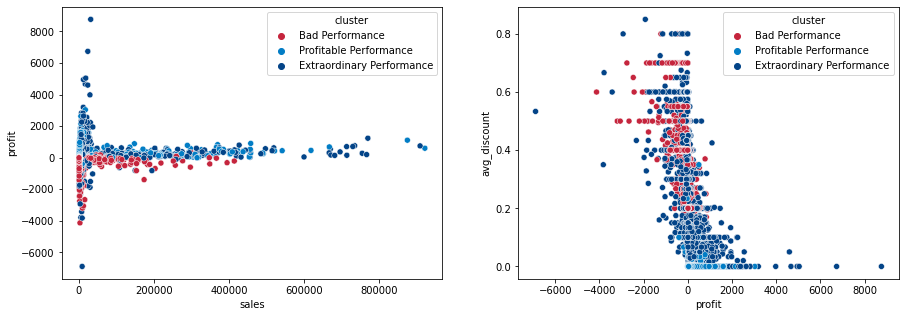

In [114]:
fig()
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_aux, x='sales', y='profit', hue='cluster', palette=get_cluster_palette(segments));
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_aux, x='profit', y='avg_discount', hue='cluster', palette=get_cluster_palette(segments));

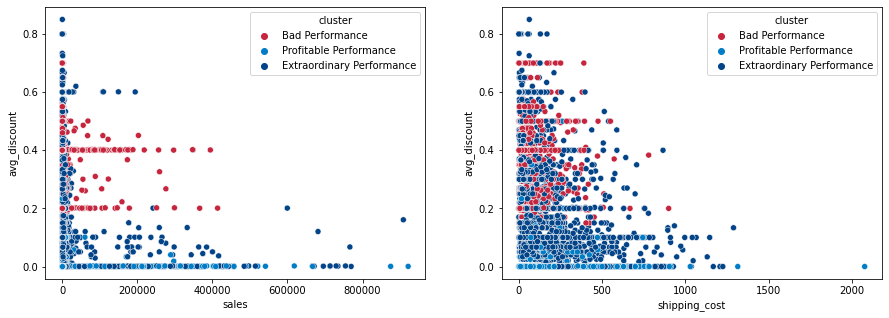

In [115]:
fig()
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_aux, x='sales', y='avg_discount', hue='cluster', palette=get_cluster_palette(segments));
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_aux, x='shipping_cost', y='avg_discount', hue='cluster', palette=get_cluster_palette(segments));

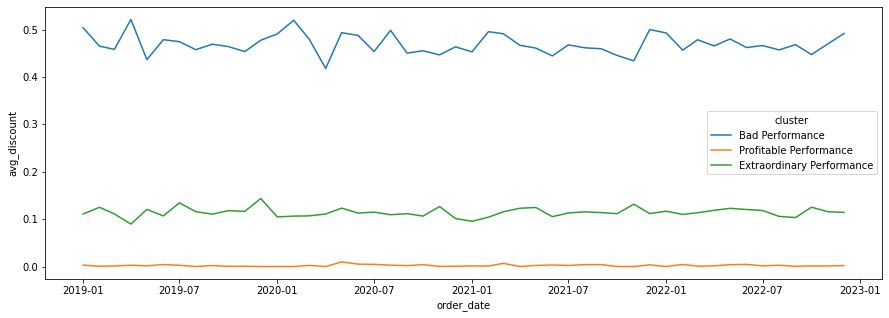

In [117]:
fig()
y = 'avg_discount'
df = df_aux.groupby(['cluster', df_aux['order_date'].dt.to_period('M')])[[y]].mean().reset_index()
df['order_date'] = df['order_date'].dt.to_timestamp()

sns.lineplot(data=df,
            x='order_date', y=y, hue='cluster')
plt.show()

## Next Steps

**Analyze Over Time**

    ps: yes, it's consistent

**What Exactly Causes Negative Profit? A specific city, produt?**

**Recommendation system would help with the cross-selling strategy, but a Market Basket Analysis is simpler and may accomplish similar returns.**